In [1]:
import os
import tejapi
import pandas as pd
import numpy as np
os.environ['TEJAPI_KEY'] = "VQZyPSb1cxDuftfxpq4ZJcs0KZenR1"
os.environ['TEJAPI_BASE'] = "http://10.10.10.66"
# os.environ['TEJAPI_KEY'] = "your key"
# os.environ['TEJAPI_BASE'] = "https://api.tej.com.tw"
start = '2018-04-01'
end = '2019-03-31'

In [2]:
from zipline.sources.TEJ_Api_Data import get_universe
pool = get_universe(start, end, mkt = ['TWSE', 'OTC'], stktp_e=['Common Stock-Foreign', 'Common Stock'])
len(pool)

Currently used TEJ API key call quota 352/100000 (0.35%)
Currently used TEJ API key data quota 5664750/10000000 (56.65%)


1721

In [3]:
import TejToolAPI
start_dt, end_dt = pd.Timestamp(start, tz='utc'), pd.Timestamp(end, tz='utc')

df = TejToolAPI.get_history_data(start = start_dt,
                                   end = end_dt,
                                   ticker = pool,
                                   columns = ['Component_Stock_of_MSCI_TW_Fg'],
                                   transfer_to_chinese = False)

df

Currently used TEJ API key call quota 458/100000 (0.46%)
Currently used TEJ API key data quota 7277597/10000000 (72.78%)


,coid,mdate,Component_Stock_of_MSCI_TW_Fg
0,1101,2018-04-02,Y
1,1101,2018-04-03,Y
2,1101,2018-04-09,Y
3,1101,2018-04-10,Y
4,1101,2018-04-11,Y
...,...,...,...
408241,9962,2019-03-25,
408242,9962,2019-03-26,
408243,9962,2019-03-27,
408244,9962,2019-03-28,


In [4]:
df = df.drop_duplicates(subset=['coid'])
df_filtered = df[df['Component_Stock_of_MSCI_TW_Fg'] == 'Y']
new_pool = df_filtered['coid'].to_list()
len(new_pool)

91

In [5]:
new_tickers = ' '.join(new_pool)

start = '2019-04-01'
end = '2024-04-01'
start_dt, end_dt = pd.Timestamp(start, tz='utc'), pd.Timestamp(end, tz='utc')
os.environ['ticker'] = new_tickers +' IX0001'
os.environ['mdate'] = start+' '+end

In [6]:
!zipline ingest -b tquant

[2024-04-30 03:14:24.020613] INFO: zipline.data.bundles.core: Ingesting tquant.
Merging daily equity files:  [####################################]    
Currently used TEJ API key call quota 466/100000 (0.47%)
Currently used TEJ API key data quota 7551039/10000000 (75.51%)
[2024-04-30 03:15:30.677705] INFO: zipline.data.bundles.core: Ingest tquant successfully.


In [7]:
!zipline bundle-info

tickers :
1101 1102 1216 1227 1301 1303 1326 1402 1434 1476
1504 1590 2002 2049 2105 2207 2301 2303 2308 2317
2324 2327 2330 2337 2344 2347 2353 2354 2356 2357
2377 2379 2382 2385 2395 2408 2409 2412 2454 2474
2498 2542 2603 2610 2618 2633 2801 2823 2834 2880
2881 2882 2883 2884 2885 2886 2887 2888 2890 2891
2892 2912 2915 3008 3034 3045 3105 3231 3481 3682
3702 3711 4147 4904 4938 4958 5347 5871 5880 6239
6456 6488 6505 8299 8464 9904 9910 9921 9945 IX0001

start_date : 20190401.
end_date : 20240401.


In [8]:
from zipline.pipeline.filters import StaticAssets
from zipline.data import bundles
bundle = bundles.load('tquant')
benchmark_asset = bundle.asset_finder.lookup_symbol('IX0001',as_of_date = None)

In [9]:
from zipline.pipeline import Pipeline
from zipline.TQresearch.tej_pipeline import run_pipeline
from zipline.pipeline.factors import IchimokuKinkoHyo, TrueRange, CustomFactor
from zipline.pipeline.data import TWEquityPricing, EquityPricing
from zipline.utils.math_utils import nanmax
from numpy import dstack

class AverageTrueRange(CustomFactor):

    inputs = (
        EquityPricing.high,
        EquityPricing.low,
        EquityPricing.close,
    )
    
    window_length = 10

    outputs = ["TR", "ATR"]
    
    def compute(self, today, assets, out, highs, lows, closes):

        high_to_low = highs[1:] - lows[1:]
        high_to_prev_close = abs(highs[1:] - closes[:-1])
        low_to_prev_close = abs(lows[1:] - closes[:-1])
        tr_current = nanmax(
            dstack(
                (
                    high_to_low,
                    high_to_prev_close,
                    low_to_prev_close,
                )
            ),
            2,
        )

        sma_atr_values = np.mean(tr_current, axis=0)
        
        out.TR = tr_current[-1]
        out.ATR = sma_atr_values

def make_pipeline():
    
    Ich = IchimokuKinkoHyo(
        inputs = [TWEquityPricing.high, TWEquityPricing.low, TWEquityPricing.close],
        window_length = 52,
    )
    atr = AverageTrueRange(inputs = [TWEquityPricing.high, TWEquityPricing.low, TWEquityPricing.close],
        window_length = 52,
    )
    
    return Pipeline(
        columns = {
            'curr_price': TWEquityPricing.close.latest,
            "tenkan_sen": Ich.tenkan_sen,
            "kijun_sen": Ich.kijun_sen,
            "senkou_span_a": Ich.senkou_span_a,
            "senkou_span_b": Ich.senkou_span_b,
            'cloud_red': Ich.senkou_span_a < Ich.senkou_span_b,
            "chikou_span": Ich.chikou_span,
            'stop_loss': atr.ATR,
    },
        # screen = ~StaticAssets([benchmark_asset])
        screen = ~StaticAssets([benchmark_asset]) & (Ich.senkou_span_a > 0) & (Ich.senkou_span_b > 0)
    )
my_pipeline = run_pipeline(make_pipeline(), start_dt, end_dt)
my_pipeline

curr_price  tenkan_sen  \
2019-06-18 00:00:00+00:00 Equity(0 [1101])        44.70      43.900   
                          Equity(1 [1102])        46.75      46.150   
                          Equity(2 [1216])        79.90      80.900   
                          Equity(3 [1227])        60.00      59.100   
                          Equity(4 [1301])       112.50     110.500   
...                                                 ...         ...   
2024-04-01 00:00:00+00:00 Equity(84 [8464])      351.50     353.250   
                          Equity(85 [9904])       36.15      34.900   
                          Equity(86 [9910])      160.50     161.750   
                          Equity(87 [9921])      217.50     225.250   
                          Equity(88 [9945])       35.15      34.775   

                                             kijun_sen  senkou_span_a  \
2019-06-18 00:00:00+00:00 Equity(0 [1101])      43.075        43.4875   
                          Equity(1 [1102])      43.700        44.9250   
                          Equity(2 [1216])      79.000        79.9500   
                          Equity(3 [1227])      57.000        58.0500   
                          Equity(4 [1301])     110.000       110.2500   
...                                                ...            ...   
2024-04-01 00:00:00+00:00 Equity(84 [8464])    364.750       359.0000   
                          Equity(85 [9904])     33.275        34.0875   
                          Equity(86 [9910])    162.500       162.1250   
                          Equity(87 [9921])    215.000       220.1250   
                          Equity(88 [9945])     35.500        35.1375   

                                             senkou_span_b  cloud_red  \
2019-06-18 00:00:00+00:00 Equity(0 [1101])          42.750      False   
                          Equity(1 [1102])          43.575      False   
                          Equity(2 [1216])          76.500      False   
                          Equity(3 [1227])          56.050      False   
                          Equity(4 [1301])         110.250      False   
...                                                    ...        ...   
2024-04-01 00:00:00+00:00 Equity(84 [8464])        357.000      False   
                          Equity(85 [9904])         33.225      False   
                          Equity(86 [9910])        165.250       True   
                          Equity(87 [9921])        201.250      False   
                          Equity(88 [9945])         36.050       True   

                                             chikou_span  stop_loss  
2019-06-18 00:00:00+00:00 Equity(0 [1101])         42.50   0.542157  
                          Equity(1 [1102])         41.70   0.710784  
                          Equity(2 [1216])         77.30   1.241176  
                          Equity(3 [1227])         53.00   1.137255  
                          Equity(4 [1301])        109.50   1.421569  
...                                                  ...        ...  
2024-04-01 00:00:00+00:00 Equity(84 [8464])       370.00  10.450980  
                          Equity(85 [9904])        30.15   0.526471  
                          Equity(86 [9910])       166.50   3.500000  
                          Equity(87 [9921])       195.50   6.598039  
                          Equity(88 [9945])        37.05   0.594118  

[103252 rows x 8 columns]

In [10]:
from zipline.finance import slippage, commission
from zipline.api import *

def initialize(context):
    set_slippage(slippage.VolumeShareSlippage())
    set_commission(commission.Custom_TW_Commission(min_trade_cost = 20, discount = 1.0, tax = 0.003))
    attach_pipeline(make_pipeline(), 'mystrats')
    set_benchmark(symbol('IX0001'))
    context.stop_loss = {}
    context.trailing_stop = {}
    context.last_buy_price = {}
    context.trailing_count = {}
    context.holding = {}
    context.buy_count = {}

In [11]:
def handle_data(context, data):
    out_dir = pipeline_output('mystrats')

    for i in out_dir.index:
        sym = i.symbol
        curr_price = out_dir.loc[i, 'curr_price']
        tenkan_sen = out_dir.loc[i, 'tenkan_sen']
        kijun_sen = out_dir.loc[i, 'kijun_sen']
        senkou_span_a = out_dir.loc[i, 'senkou_span_a']
        senkou_span_b = out_dir.loc[i, 'senkou_span_b']
        cloud_red = out_dir.loc[i, 'cloud_red']
        chikou_span = out_dir.loc[i, 'chikou_span']
        stop_loss = out_dir.loc[i, 'stop_loss']
        cash_position = context.portfolio.cash  # record cash position
        stock_position = context.portfolio.positions[i].amount  # record stock holding

        if context.stop_loss.get(f'{i}') is None:
            context.stop_loss[f'{i}'] = 0
            
        if context.trailing_stop.get(f'{i}') is None:
            context.trailing_stop[f'{i}'] = False
            
        if context.last_buy_price.get(f'{i}') is None:
            context.last_buy_price[f'{i}'] = 0

        if context.holding.get(f'{i}') is None:
            context.holding[f'{i}'] = False
            
        if context.trailing_count.get(f'{i}') is None:
            context.trailing_count[f'{i}'] = 1

        if context.buy_count.get(f'{i}') is None:
            context.buy_count[f'{i}'] = 0
            
        buy, sell = False, False
        record(
           **{
                f'price_{sym}':curr_price,
                f'buy_{sym}':buy,
                f'sell_{sym}':sell,
                f'tenkan_sen_{sym}': tenkan_sen,
                f'kijun_sen_{sym}': kijun_sen,
                f'cloud_red_{sym}': cloud_red,
                f'senkou_span_a_{sym}': senkou_span_a,
                f'senkou_span_b_{sym}': senkou_span_b,
                f'chikou_span_{sym}': chikou_span,
            }
        )
        
        # 三役好轉 (tenkan_sen > kijun_sen*1.015 : avoid the Darvas Box Theory)
        if (curr_price > senkou_span_b) and (cloud_red == True) and (tenkan_sen > kijun_sen*1.01) and (context.buy_count[f'{i}'] <= 5):
            order_percent(i, 0.01)
            buy = True
            context.stop_loss[f'{i}'] = curr_price - (1.25 * stop_loss)
            context.last_buy_price[f'{i}'] = curr_price
            record(
                **{
                    f'buy_{sym}':buy
                }
            )
            context.holding[f'{i}'] = True
            context.buy_count[f'{i}'] += 1

        # reset stop loss point
        if (curr_price >= (1.3**context.trailing_count[f'{i}'])*context.last_buy_price[f'{i}']) and (context.holding[f'{i}'] == True) and (context.trailing_stop[f'{i}'] == False):
            context.stop_loss[f'{i}'] = 1.3*context.stop_loss[f'{i}']
            context.trailing_stop[f'{i}'] = True
            context.trailing_count[f'{i}'] += 1
        elif (curr_price >= (1.3**context.trailing_count[f'{i}'])*context.last_buy_price[f'{i}']) and (context.holding[f'{i}'] == True) and (context.trailing_stop[f'{i}'] == True):
            context.stop_loss[f'{i}'] = 1.3*context.stop_loss[f'{i}']
            context.trailing_count[f'{i}'] += 1
        
        if (curr_price <= context.stop_loss[f'{i}']) and (context.holding[f'{i}'] == True):
            order_target(i, 0)
            sell = True
            context.stop_loss[f'{i}'] = None
            context.trailing_stop[f'{i}'] = None
            context.trailing_count[f'{i}'] = None
            record(
                **{
                    f'sell_{sym}':sell
                }
            )
            context.holding[f'{i}'] = None
            context.buy_count[f'{i}'] = None

In [12]:
# print 3105 transaction plot
def analyze(context, perf):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    perf.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel("Portfolio value (NTD)")
    ax2 = fig.add_subplot(212)
    ax2.set_ylabel("Stock Price (NTD)")
    perf.price_3105.plot(ax=ax2, color='black', alpha=0.8)
    perf.tenkan_sen_3105.plot(ax=ax2, color='blue', alpha=0.3)
    perf.kijun_sen_3105.plot(ax=ax2, color='red', alpha=0.3)
    perf.senkou_span_a_3105.plot(ax=ax2, color='green', alpha=0.3)
    perf.senkou_span_b_3105.plot(ax=ax2, color='red', alpha=0.3)
    perf.chikou_span_3105.plot(ax=ax2, color='orange', alpha=0.3)
    
    buy_status, sell_status = perf.buy_3105, perf.sell_3105
    buy_status.fillna(False, inplace=True)
    sell_status.fillna(False, inplace=True)

    a = perf.senkou_span_a_3105
    b = perf.senkou_span_b_3105
    ax2.fill_between(perf.period_close, a, b, where=a >= b, color='green', alpha=0.3, label='Cloud')
    ax2.fill_between(perf.period_close, a, b, where=a < b, color='red', alpha=0.3)
    
    ax2.plot( # Buy Signal
        perf.index[perf.buy_3105],
        perf.loc[perf.buy_3105, 'price_3105'],
        '^',
        markersize=7,
        color='red'
    )
    ax2.plot( # Sell Signal
        perf.index[perf.sell_3105],
        perf.loc[perf.sell_3105, 'price_3105'],
        'v',
        markersize=7,
        color='green'
    )
    
    plt.legend(loc=0)
    plt.gcf().set_size_inches(18,12)
    plt.show()

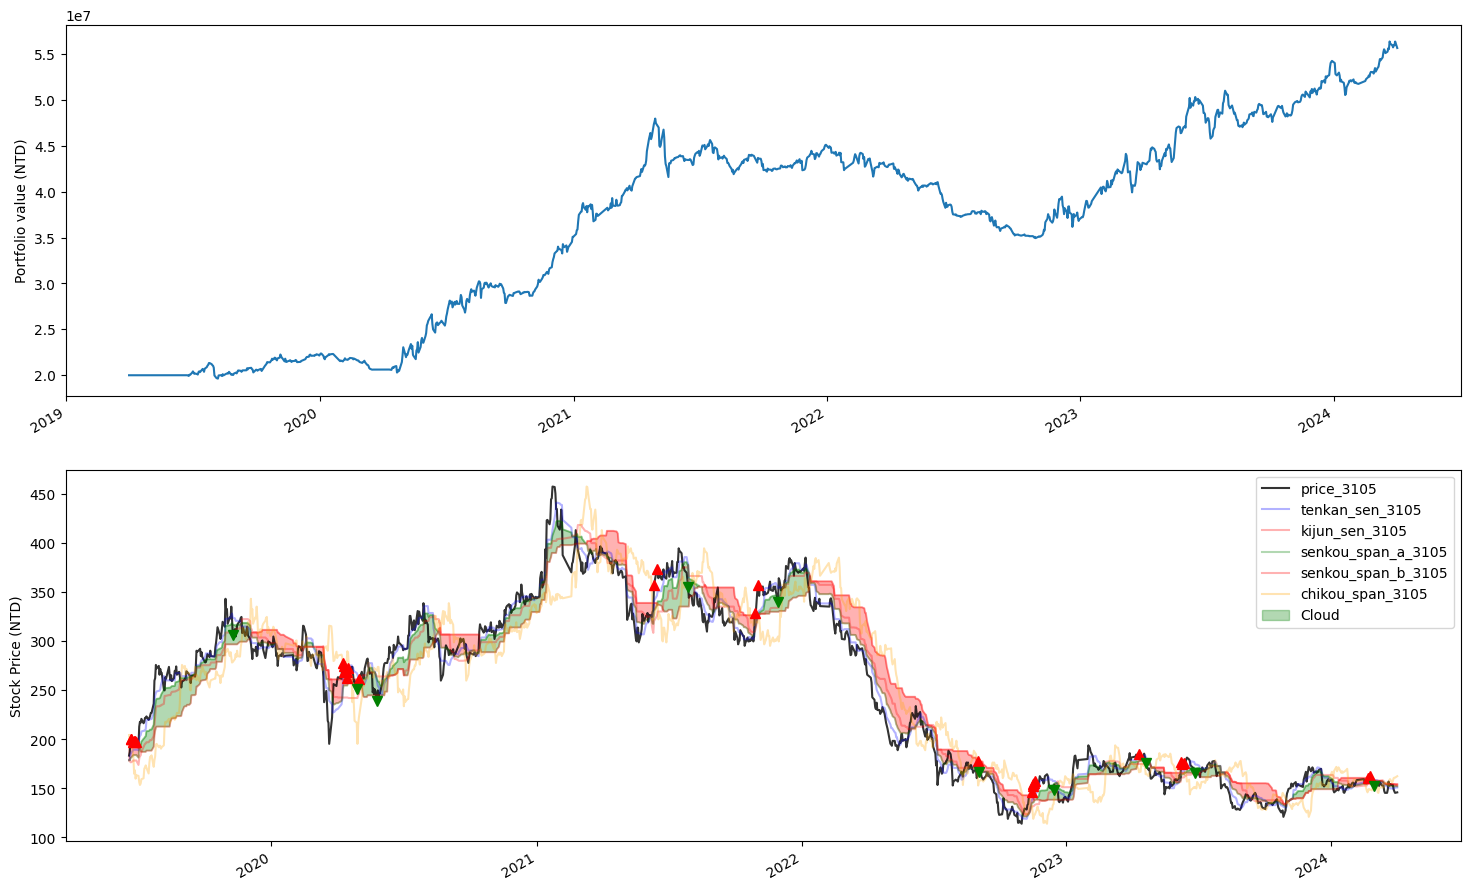

,period_open,period_close,starting_cash,ending_cash,portfolio_value,longs_count,shorts_count,long_value,short_value,returns,...,chikou_span_9921,price_9945,buy_9945,sell_9945,tenkan_sen_9945,kijun_sen_9945,cloud_red_9945,senkou_span_a_9945,senkou_span_b_9945,chikou_span_9945
2019-04-01 13:30:00+08:00,2019-04-01 09:01:00+08:00,2019-04-01 13:30:00+08:00,2.000000e+07,2.000000e+07,2.000000e+07,0,0,0.00,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-02 13:30:00+08:00,2019-04-02 09:01:00+08:00,2019-04-02 13:30:00+08:00,2.000000e+07,2.000000e+07,2.000000e+07,0,0,0.00,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-03 13:30:00+08:00,2019-04-03 09:01:00+08:00,2019-04-03 13:30:00+08:00,2.000000e+07,2.000000e+07,2.000000e+07,0,0,0.00,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-08 13:30:00+08:00,2019-04-08 09:01:00+08:00,2019-04-08 13:30:00+08:00,2.000000e+07,2.000000e+07,2.000000e+07,0,0,0.00,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-09 13:30:00+08:00,2019-04-09 09:01:00+08:00,2019-04-09 13:30:00+08:00,2.000000e+07,2.000000e+07,2.000000e+07,0,0,0.00,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-26 13:30:00+08:00,2024-03-26 09:01:00+08:00,2024-03-26 13:30:00+08:00,-4.328703e+05,-9.875803e+05,5.571114e+07,29,0,56698724.25,0.0,-0.003624,...,202.0,35.15,False,False,35.400,35.5,True,35.4500,36.500,36.20
2024-03-27 13:30:00+08:00,2024-03-27 09:01:00+08:00,2024-03-27 13:30:00+08:00,-9.875803e+05,-9.875803e+05,5.597166e+07,29,0,56959238.15,0.0,0.004676,...,201.0,35.20,False,False,34.975,35.5,True,35.2375,36.400,37.15
2024-03-28 13:30:00+08:00,2024-03-28 09:01:00+08:00,2024-03-28 13:30:00+08:00,-9.875803e+05,-9.875803e+05,5.593882e+07,29,0,56926398.35,0.0,-0.000587,...,199.0,35.25,False,False,34.775,35.5,True,35.1375,36.275,36.95
2024-03-29 13:30:00+08:00,2024-03-29 09:01:00+08:00,2024-03-29 13:30:00+08:00,-9.875803e+05,-4.422707e+05,5.634348e+07,28,0,56785751.05,0.0,0.007234,...,196.5,35.05,False,False,34.775,35.5,True,35.1375,36.275,36.85


In [13]:
import matplotlib.pyplot as plt
from zipline import run_algorithm

results = run_algorithm(
    start = start_dt,
    end = end_dt,
    initialize = initialize,
    bundle = 'tquant',
    analyze = analyze,
    capital_base = 2e7,
    handle_data = handle_data
)

results

In [14]:
import pyfolio as pf
import matplotlib.pyplot as plt
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
benchmark_rets = results['benchmark_return']

Start date,2019-04-01
End date,2024-04-01
Total months,58
,Backtest
Annual return,23.554%
Cumulative returns,178.194%
Annual volatility,16.637%
Sharpe ratio,1.36
Calmar ratio,0.87
Stability,0.79
Max drawdown,-27.156%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,27.16,2021-04-28,2022-10-28,2023-06-02,513
1,9.25,2020-01-03,2020-04-21,2020-04-30,75
2,9.01,2023-06-15,2023-07-07,2023-07-27,29
3,7.97,2019-07-26,2019-08-07,2019-10-17,55
4,7.83,2020-08-17,2020-09-25,2020-11-11,60


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS


Stress Events,mean,min,max
New Normal,0.09%,-5.20%,4.28%


Top 10 long positions of all time,max
sid,
2603,12.84%
4147,10.54%
3105,9.48%
3034,9.15%
1590,8.34%
1504,8.29%
2308,8.11%
8299,7.87%
2330,7.72%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
2603,12.84%
4147,10.54%
3105,9.48%
3034,9.15%
1590,8.34%
1504,8.29%
2308,8.11%
8299,7.87%
2330,7.72%


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei


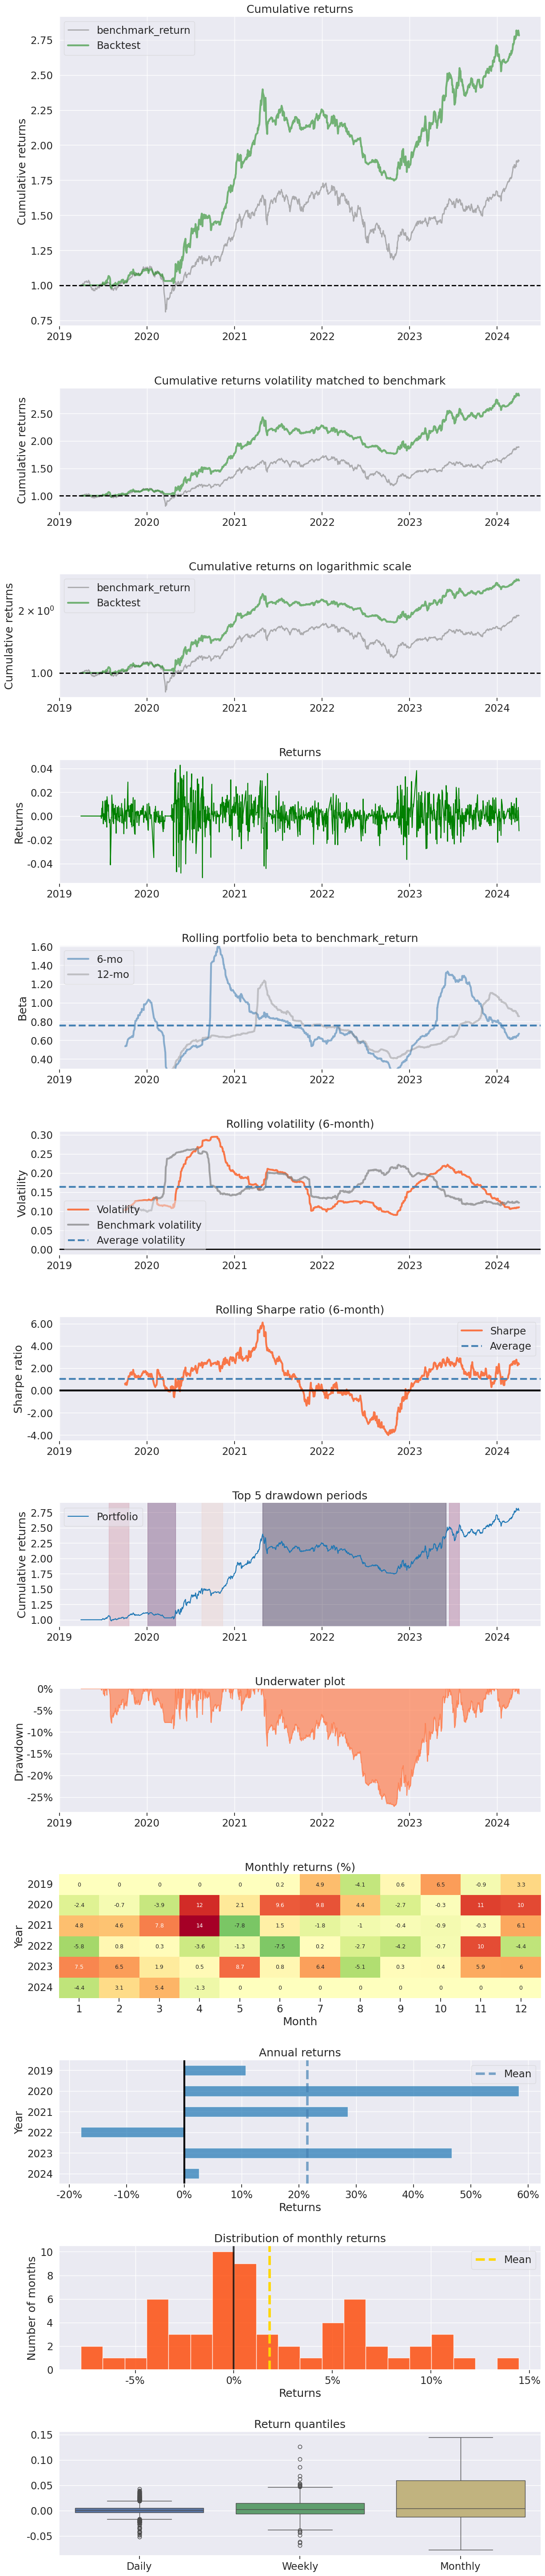

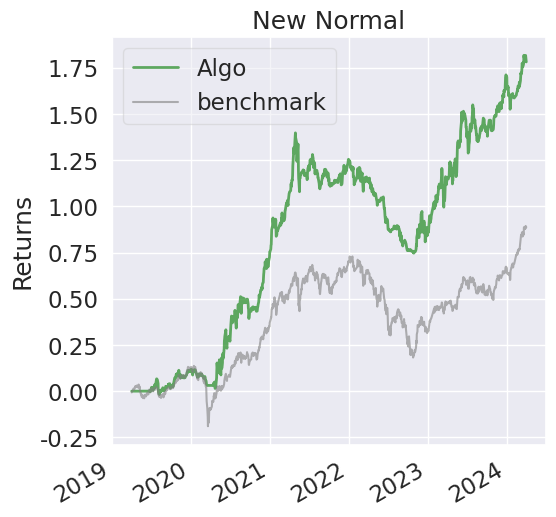

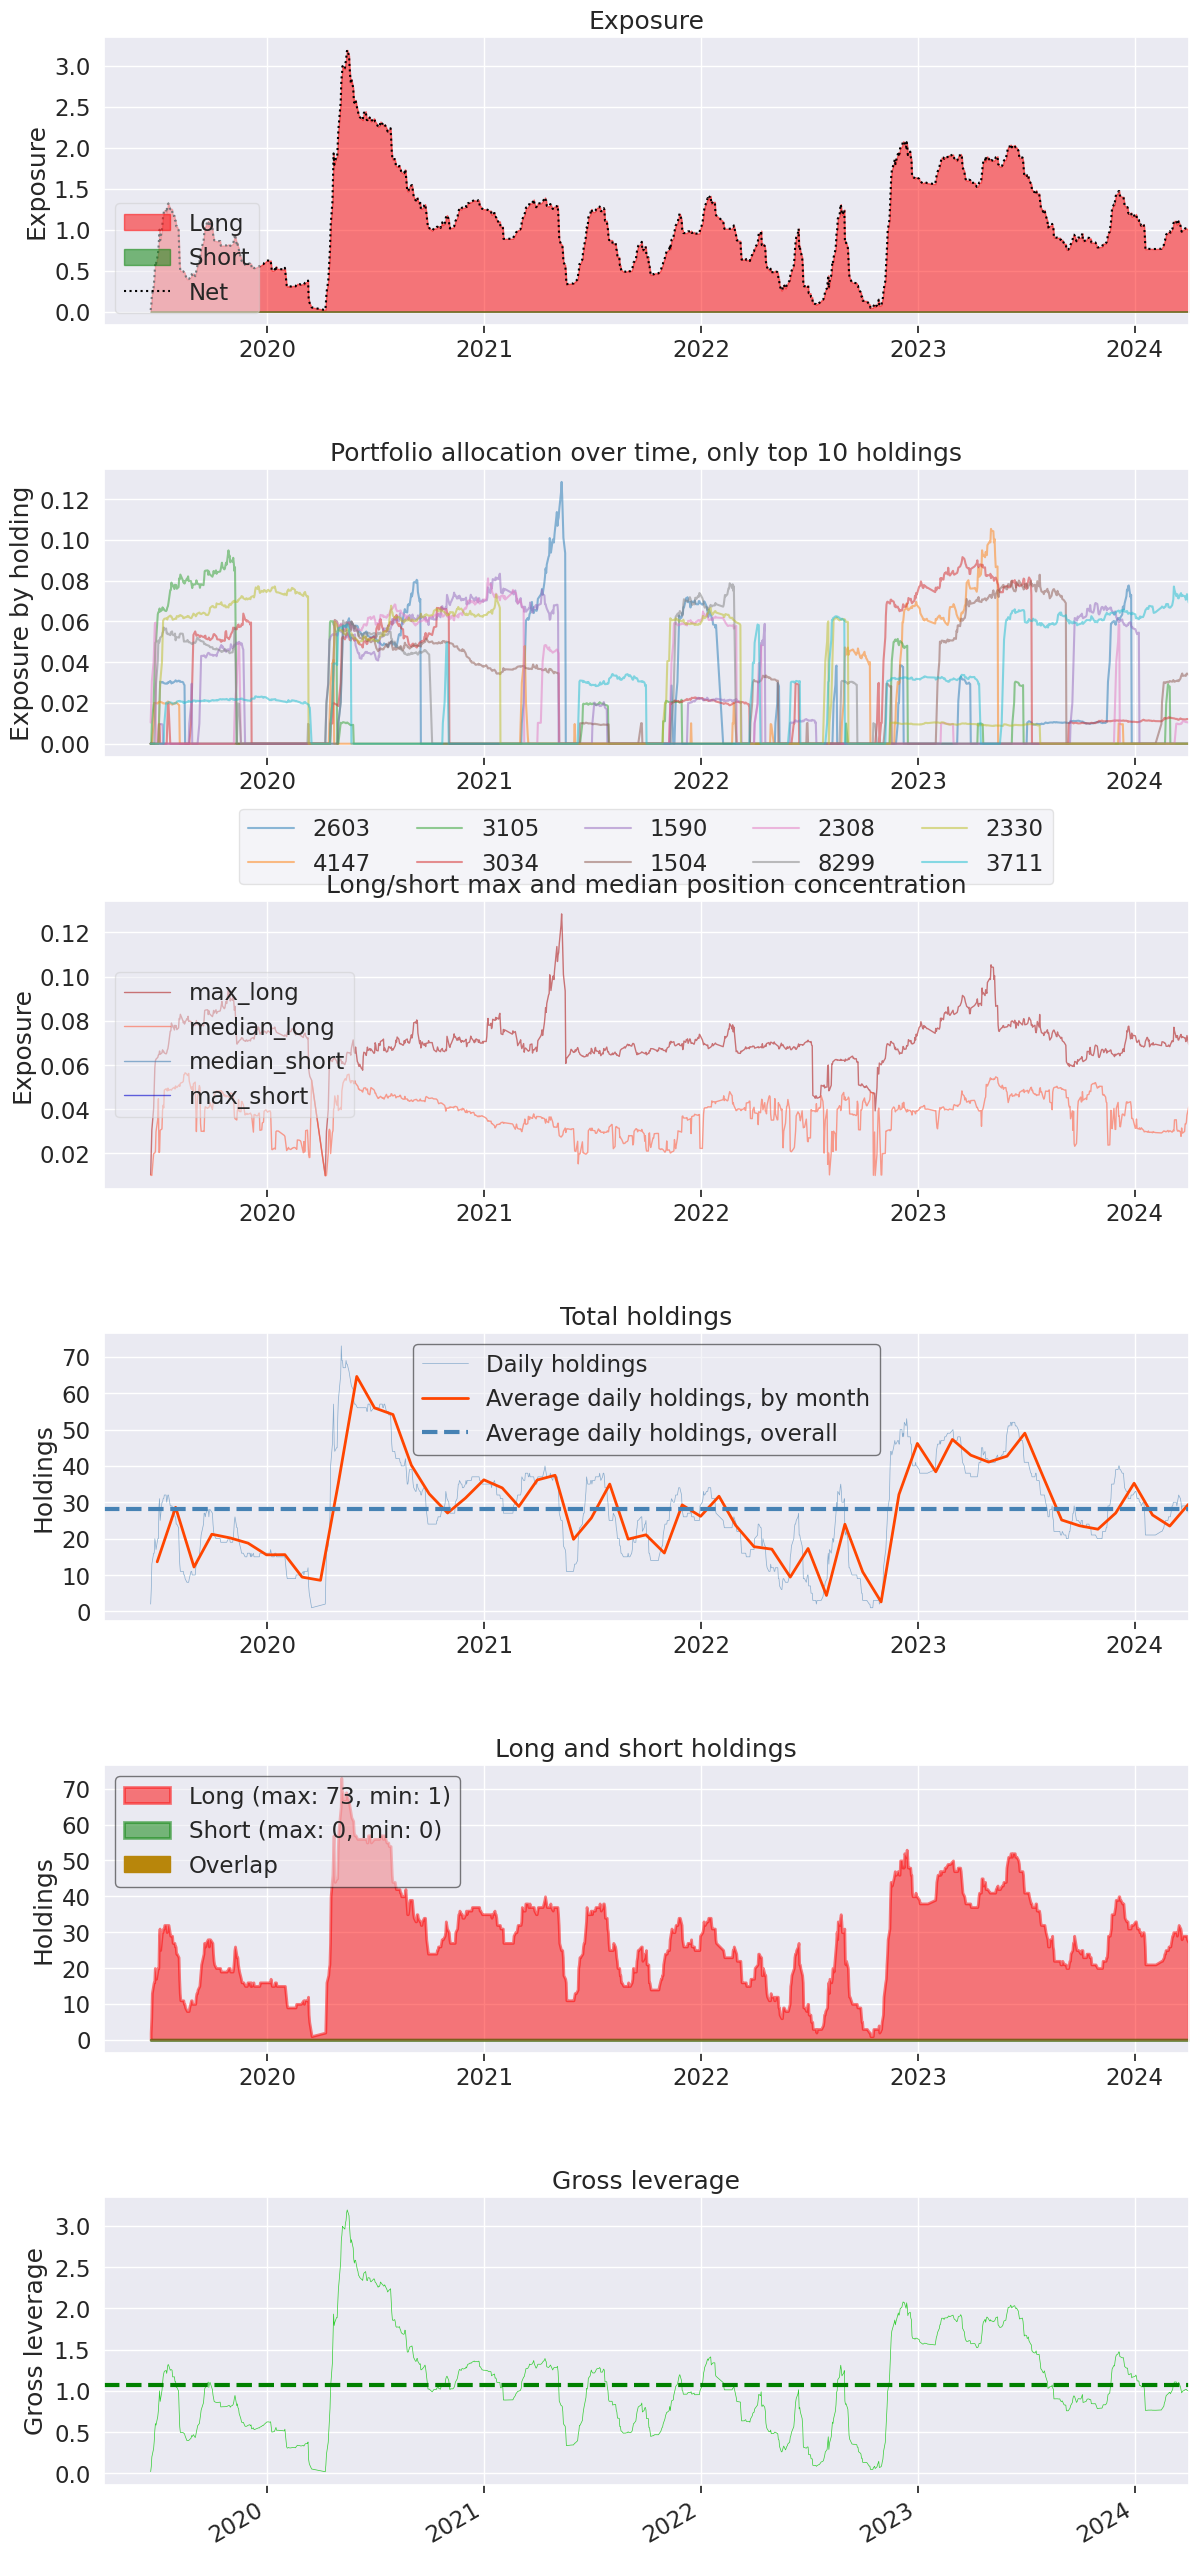

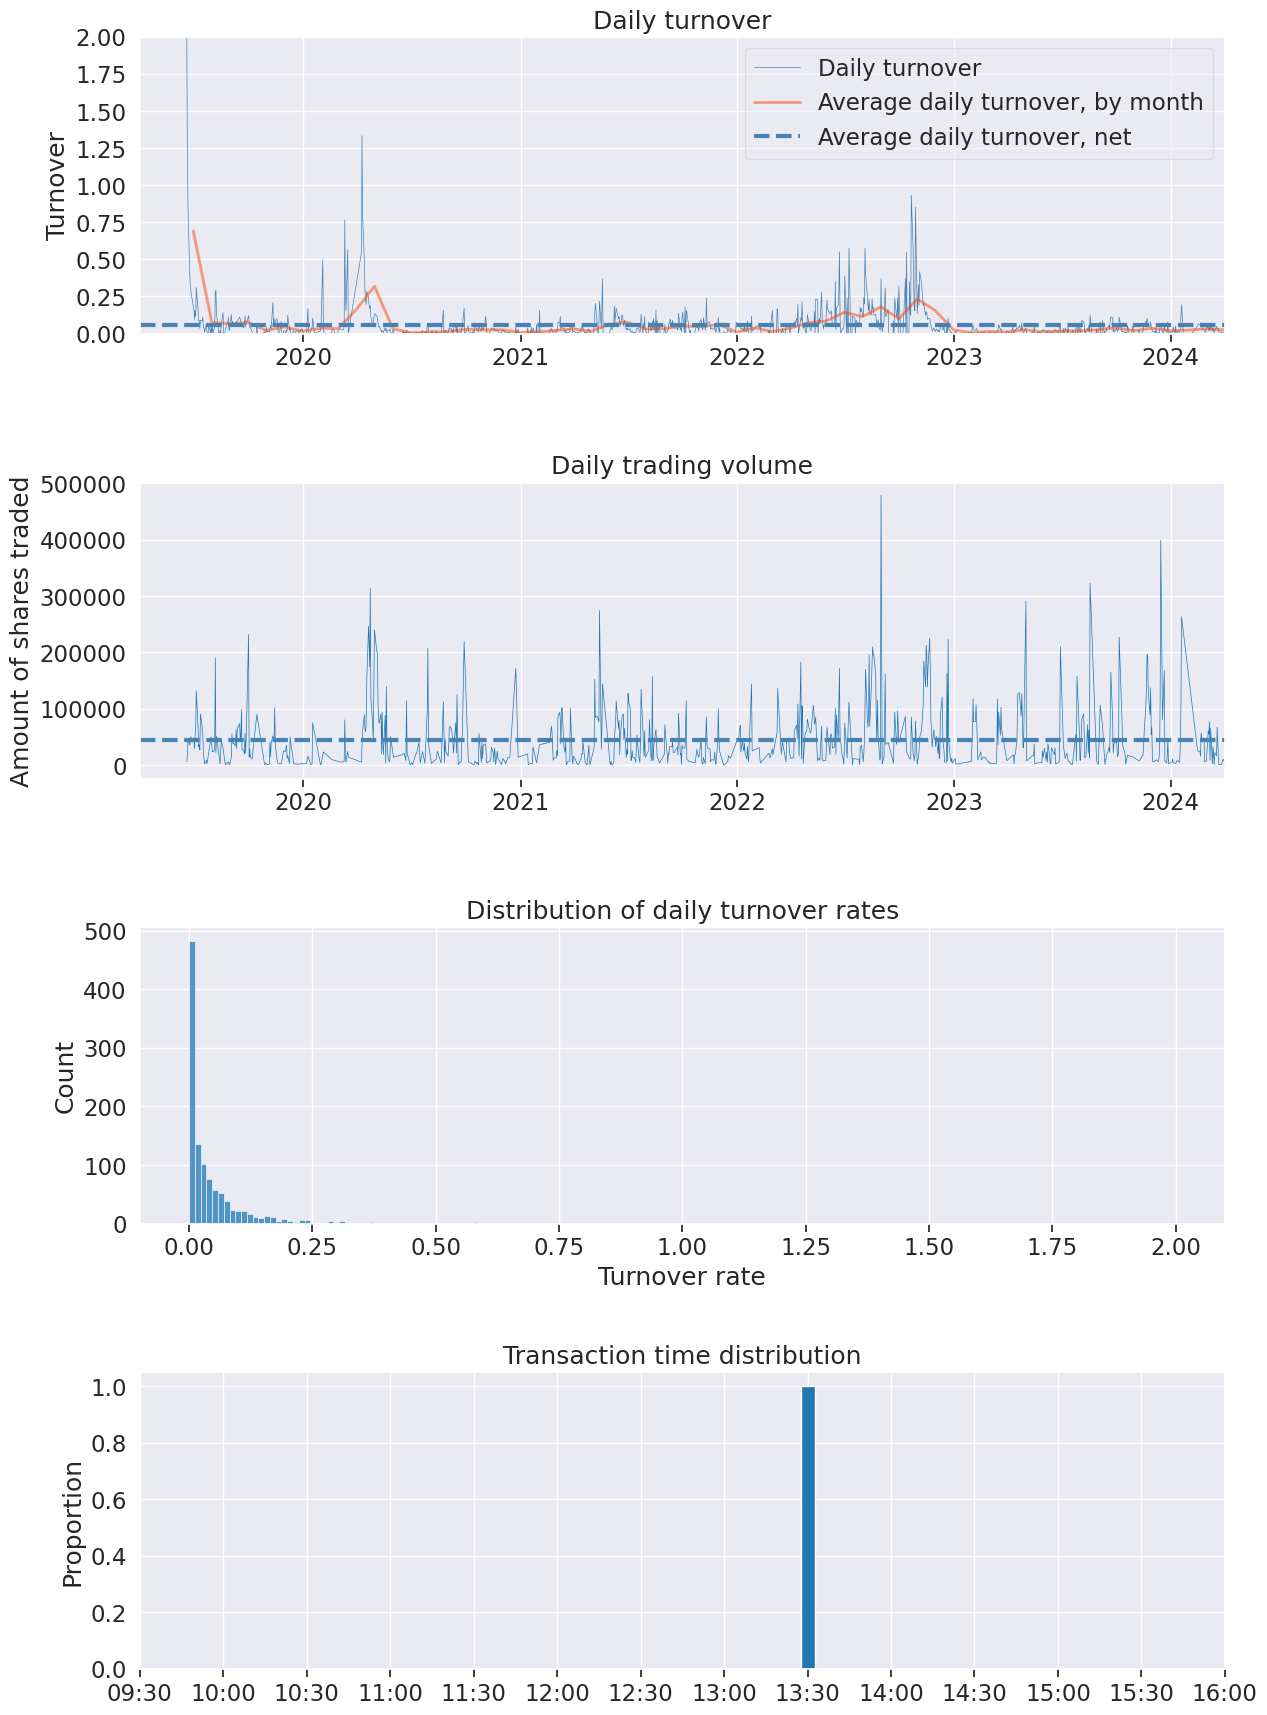

In [15]:
pf.tears.create_full_tear_sheet(returns=returns,
                                positions=positions,
                                transactions=transactions,
                                benchmark_rets=benchmark_rets
                                )

In [16]:
# allow us to check different stocks
def graph(coid, backtested):
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    equity = bundle.asset_finder.lookup_symbol(f'{coid}',as_of_date = None)

    dates = my_pipeline.index.get_level_values(0).drop_duplicates()
    curr_price = my_pipeline['curr_price'].loc[:, equity]
    tenkan_sen = my_pipeline['tenkan_sen'].loc[:, equity]
    kijun_sen = my_pipeline['kijun_sen'].loc[:, equity]
    kijun_sen = my_pipeline['kijun_sen'].loc[:, equity]
    senkou_span_a = my_pipeline['senkou_span_a'].loc[:, equity]
    senkou_span_b = my_pipeline['senkou_span_b'].loc[:, equity]
    chikou_span = my_pipeline['chikou_span'].loc[:, equity]
    plt.figure(figsize=(20, 5))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.plot(dates, curr_price, label='Current Price', color='black', alpha=0.8)
    plt.plot(dates, tenkan_sen, label='Tenkan Sen', color='blue', alpha=0.3)
    plt.plot(dates, kijun_sen, label='Kijun Sen', color='red', alpha=0.3)
    plt.plot(dates, senkou_span_a, color='green', alpha=0.3)
    plt.plot(dates, senkou_span_b, color='red', alpha=0.3)
    plt.fill_between(dates, senkou_span_a, senkou_span_b, where=senkou_span_a >= senkou_span_b, color='green', alpha=0.3, label='Senkou Span A/B')
    plt.fill_between(dates, senkou_span_a, senkou_span_b, where=senkou_span_a < senkou_span_b, color='red', alpha=0.3)
    plt.plot(dates, chikou_span, label='Chikou Sen', color='orange', alpha=0.3)

    if backtested is True:
        plt.plot(results.index[results[f'buy_{coid}'] == True], results.loc[results[f'buy_{coid}'] == True , f'price_{coid}'], '^', markersize=7, color='red')
        plt.plot(results.index[results[f'sell_{coid}'] == True], results.loc[results[f'sell_{coid}'] == True, f'price_{coid}'], 'v', markersize=7, color='green')
            
    plt.legend()
    plt.title(f'Ichimoku Kinko Hyo {coid}')
    plt.xlabel('Date')
    plt.ylabel('Stock Price (NTD)')
    plt.gcf().autofmt_xdate()
    plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei


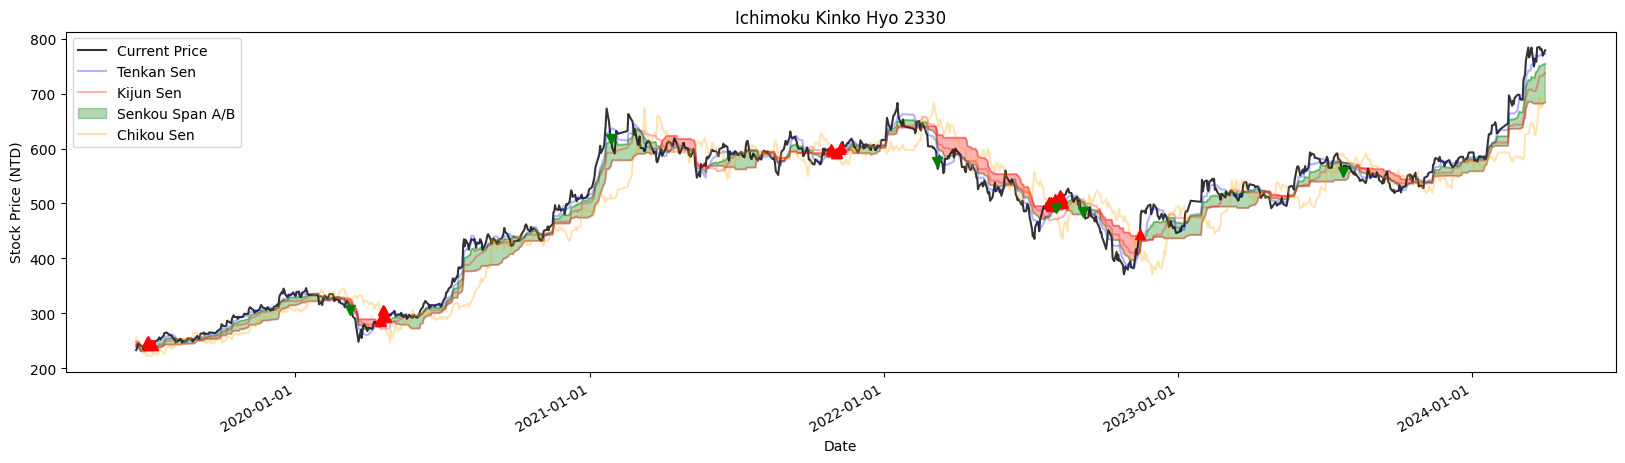

In [17]:
graph(2330, True)